# Reinforcement learning: CartPole game

# Author: Huygens Ravelomanana
# Description:
+ We solved the problem for 1500 steps or frames.
+ We found out that the more episodes we use the more we get better performance so we used 30000 episodes. 
+ We did a random search to find the best combination of hyperparameters:     learning_rate, gamma, epsilon, bin_size (for discretization).
    * Because of this, running the whole notebook will redo the search again which takes about 38mn. 
    * It is better to run the following sections consecutively instead (since we already know the best combination):
            + Installing packages
            + Importing Libraries
            + Creating the game environment
            + Defining functions for the Q-learning process
            + Playing using the best policy

# Installing packages

In [ ]:
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb x11-utils
!pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [543 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 P

# Information about the game
**Source:**
        [openai github](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)

+ Observation:

        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf

+ Actions:

        0     Push cart to the left
        1     Push cart to the right

+ Reward:
        Reward is 1 for every step taken, including the termination step

+ Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]

+ Episode Termination:
        * Pole Angle is more than 12 degrees.
        * Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        * Episode length is greater than 200: can be changed using the environment attribute `_max_episode_steps`

# Importing Libraries

In [ ]:
import gym

import numpy as np
import pandas as pd
import seaborn as sns

import random 

# for hyperparameters search
import itertools

# not needed
# from tensorflow import keras
# import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display as ipythondisplay

sns.set(style="whitegrid")
mpl.rc('animation', html='jshtml')


# Creating the game environment

In [ ]:
env = gym.make('CartPole-v0')
env._max_episode_steps = 1500

In [ ]:
env.theta_threshold_radians

0.20943951023931953

In [ ]:
# printing the range of the observations value
# this is just to see if it corresponds to the values
# discussed at the begining.
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.n)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
2


# Defining functions for the Q-learning process

In [ ]:
# setting the number of episodes
num_episodes=30000


In [ ]:

def create_q_table(bin_size):
    """Function creating a Q-table using discretized state from
    bin_size bin size. The values in the table are sample from uniform
    distribution between -1 and 1.
    
    Input:
    ------
           bin_size (int): the bin size for the discretization.
    
    Output:
    ------
          (numpy.ndarray):  the Q-table, its shape is
                        (bin_size, bin_size, bin_size, bin_size, num_actions)
                    where num_actions if the cardinality of the action space
    """

    # The game states consists of 4 values:
    # Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity 
    # so it is 4-dimensional

    # defining a constant for the dimension of the state
    state_dim = 4 

    # we have only 2 possible actions: 0 and 1
    # defining a constant for the cardinality of the action space
    num_actions = 2
    
    # creating a numpy array of shape
    # filled with random values between -1 and 1
    q_table = np.random.uniform(low=-1,
                                high=1,
                                size=([bin_size] * state_dim + [num_actions]))
    return q_table


In [ ]:
def create_state_bins(bin_size):
    """Function creating the bins fo state space discretization.
    It creates a list of 4 numpy arrays, each arrays is a 1D array containing
    bin_size elements. The first and last elements are the 1st and the 2nd
    argument of np.linspace. The result will play the role of discrete
    state space and we are going to use them instead of the continuous one.
    
    Input:
    ------
           bin_size (int): the bin size for the discretization.
    
    Output:
    ------
          (list): list of 4 numpy.ndarray each of shape (bin_size, ).
                    The 4 arrays corresponds to
            Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity.
    """

    # we will use these discrete values for the 4 different observations
    # instead of continuous values
    bins = [np.linspace(-4.8, 4.8, bin_size),
            np.linspace(-4, 4, bin_size),
            np.linspace(-0.418, 0.418, bin_size),
            np.linspace(-4, 4, bin_size)]
    
    return bins

def discretize_state(state, bins, bin_size):
    """This function discretize the single "state state" using bins.
     Since it is more appropriate to identify discrete states with integers or
     tuples of integers we are going to use the indices of bins to identify the
     components instead of their actual float values.

    Input:
    ------
           state (tuple): a single continuous state with 4 components
                Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity.

           bins (list): The bins wich contains the discrete values.

           bin_size (int): the bin size for the discretization.
    
    Output:
    ------
          (tuple): tuple of 4 elements which consists of the index of the input 
                  state "state" in the bins.
    """

    # creating a list which will contain the discretized version of
    # the input (state) i.e discrete:
    # Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity
    # since we are working with dicrete values we can identify the state with
    # their index 
    state_index = []

    # looping through the 4 components of the state
    for i in range(4):
        # appending the discrete version of each component
        # we use numpy.digitize to get the index corresponding to the state
        # in the previously defined bins
        state_index.append(np.digitize(state[i],bins[i]) - 1)
    
        # the -1 is because the output index of numpy.digitize is such that
        # bins[index-1] <= x < bins[index] if bins is monotonically increasing
        # which is our case here

    # converting the list into a tuple
    # since observatin should be a tuple
    state_index = tuple(state_index)

    return state_index

In [ ]:
# defining a policy function
def choose_action(q_table, discrete_state, epsilon):
    """
       Function for an epsilon-greedy choice of action in the Q-table
       q_table given a disrete state discrete_state and epsilon.

    Input:
    ------
           q_table (numpy.ndarray): the Q-table

           discrete_state (tuple): tuple of 4-elements representing a
                                  discrete state.

           epsilon (float): the probability below which we will not choose
                             the greedy action.
    
    Output:
    ------
          (tuple): tuple of 4 elements which consists of the index of the input 
                  state "state" in the bins.
    
    """
    if np.random.uniform(0,1) < epsilon:
        # getting random action
        action = np.random.randint(0, env.action_space.n)
    else:
        # getting action from the Q-table
        action = np.argmax(q_table[discrete_state])
    
    return action

In [ ]:
# defining a function which does a tabular Q-learning
# it will return the final Q-table

def q_learn(num_episodes,  gamma, learning_rate, epsilon, bins, bin_size=70):
    """Function for the Q-learning. it runs the Q-learning algorithms.
    
    Input:
    ------
           num_episodes (int): number of episodes to use in the algorithm

           gamma (float): the discount factor.

           learning_rate (float): the learning rate.

           epsilon (float): the starting epsilon probability to be used for the
                            epsilon-greedy choice of action
          
           bins (list): the bins for the discrete states.

           bin_size (int): the bin size for the discretization.
    
    Output:
    ------
         q_table  (numpy.ndarray):  the Q-table
        
         return_list (list): lists of the return (as sum of rewards)
                             for each episode.
    
    """
    # the environement is the globaly defined env

    # setting random seed for reproducibility
    env.seed(1)
    np.random.seed(1)

    # the parameters for decaying epsilon
    START_EPSILON_DECAYING = 1
    END_EPSILON_DECAYING = num_episodes//2
    epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

    # creating a Q-table with random values
    q_table = create_q_table(bin_size)

    # return list
    return_list = []

    # playing all the episodes
    for i in range(num_episodes):

        # initializing the return
        episode_return = 0

        # reseting the environement to "initial" state
        obs = env.reset()
        state =  discretize_state(obs, bins, bin_size)

        # initialize done to false (i.e play is not done)
        done = False

        # playing until the end (end means done=True)
        while not done:

            # choosing an action
            a = choose_action(q_table, state, epsilon)

            # playing, doing the action
            obs_prime, r, done, _ = env.step(a)

            # discretize the resulting state
            state_prime =  discretize_state(obs_prime, bins, bin_size)

            # updating the Q-table
            if not done:
                # defining a pseudo-target
                y = r + gamma * np.max(q_table[state_prime])

                # the update rule
                q_table[state + (a,)] = q_table[state + (a,)] +\
                                    learning_rate * (y-q_table[state + (a,)])

            # elif bins[2][state[2]] < env.theta_threshold_radians:
            #     q_table[state + (a,)] = 0

            # adding the current reward to the  return
            episode_return += r

            # updating the current state
            state = state_prime
        
        # appending the current episode return to the return list
        return_list.append(episode_return)

        # decaying epsilon
        if END_EPSILON_DECAYING >= num_episodes >= START_EPSILON_DECAYING:
            epsilon -= epsilon_decay_value

    return q_table, return_list

# Searching for the best hyperparameters

## Creating list of hyperparameters

In [ ]:
# we tried few lists and removed suboptimal values from the list after
#  seeing the result. The list below is the last we used.
lr_list = [0.2, 0.3]
gamma_list = [0.99, 0.995, 0.999]
epsilon_list = [0.3, 0.4, 0.5]
bin_size_list = [50, 60, 70]

In [ ]:
# creating the different possible combinations of  hyperparameters based
# on our 4 lists of hyperparameters values (cartesian product with itertools)
hyperparameters_iter = itertools.product(lr_list,
                                         gamma_list,
                                         epsilon_list,
                                         bin_size_list)

# itertools.product() returns an iterator so we have to convert it into a list
hyperparameters_list = list(hyperparameters_iter)

## Randomly choosing 10 different combinations among all the possible one

In [ ]:
# using random.sample to randomly pick 10 hyperparameters combinations
# out of all the possible one in parameters_list

# setting seed for random in order to get reproducible results
random.seed(1)
random_hyperparameters = random.sample(hyperparameters_list, 10)

# looking at the samples
random_hyperparameters

[(0.2, 0.99, 0.5, 70),
 (0.3, 0.995, 0.3, 50),
 (0.3, 0.999, 0.5, 50),
 (0.3, 0.999, 0.4, 50),
 (0.2, 0.99, 0.4, 60),
 (0.2, 0.995, 0.5, 60),
 (0.2, 0.99, 0.5, 60),
 (0.3, 0.99, 0.4, 60),
 (0.3, 0.99, 0.3, 60),
 (0.3, 0.99, 0.4, 50)]

## Training the 10 different Q-table models

In [ ]:
# creating a function which plays the game
# given a policy in the form of a Q-table

def play_cartPole(q_table):
    """ Function which plays the cartPole game using the policy
    corresponding to the Q-table q_table i.e given a state s
             action = argmax_{a} Q(s,a)
    Input:
    ------
          q_table  (numpy.ndarray):  the Q-table

    
    Output:
    ------
         play_return  (int):  the sum of rewards for the play.
    """

    discrete_state = discretize_state(env.reset(), bins, bin_size)
    done = False

    # since reward = 1 for each step
    # return is the same as time steps
    play_return = 0
    while not done:
        action = np.argmax(q_table[discrete_state])
        new_state, reward, done, _ = env.step(action)
        discrete_state = discretize_state(new_state, bins, bin_size)
        play_return += reward

    return play_return

def multiple_plays(num_plays, q_table):
    """ Function which plays the cartPole game exactly num_plays times
     and collect the return (sum of rewards) for each play.
    Input:
    ------
          num_plays (int): the number of times we want to play the game.

          q_table  (numpy.ndarray):  the Q-table

    
    Output:
    ------
          plays_results  (numpy.ndarray): the array of returns (sum of rewards)
                                          for each play.
          
          return_avg (float): the average return (sum of rewards) for the
                              num_plays play. 
    """

    # list for the num_play play results
    plays_results = []

    # playing the game num_plays times
    for _ in range(num_plays):
        play_return = play_cartPole(q_table)
        plays_results.append(play_return)
    
    plays_results =  np.array(plays_results)
    return_avg = np.average(plays_results)

    return plays_results, return_avg





In [ ]:
def try_hyperparam(hyperpar_list):
    """Function fitting a Q-table for each of the hyperparameters combination
    in hyperpar_list (the input)
    
    Input:
    ------
          hyperpar_list (list): A list of  tuples of hyperparameters.
                                 Each tuple is of the form
                                 (learning_rate, gamma, epsilon, bin_size)                             
    
    Output:
    ------
          histories (dict): A dictionary with the element of the input 
                            (hyperpar_list) as keys and with the sum of 
                            rewards corresponding to the key as value 
                             [hyperpar] = return_list
 
         test_result:  A dictionary with the element of the input 
                        (hyperpar_list) as keys and with  a list
                          [plays_results, return_avg]
                        as value, where plays_results is the numyp.ndarray
                        of sum of rewards for 100 play, and return_avg is the
                        average of the average of this array
                         (average of the sum of reward)
    """

    # setting random seed to get reproducible results
    random.seed(1)    # python random seed
    np.random.seed(1)  # numpy random seed


    # creating a dictionary  to keep track of training of each model
    # the keys of the dictionary will be hyperparameters combinations
    histories = {}

    test_result = {}

    # looping through all the randomly choosen combination of hyperparameters
    # creating and  training the corresponding model
    for hyperpar in hyperpar_list:


        # unpacking the hyperparameters
        learning_rate, gamma, epsilon, bin_size = hyperpar
        
        # fitting / trainig the model

        # creating a bins for the discrete values of the 4 components
        # of a state
        bins = create_state_bins(bin_size)

        # learning the Q-table
        q_table, return_list= q_learn(num_episodes=num_episodes,
                                    gamma=gamma,
                                    learning_rate=learning_rate,
                                    epsilon=epsilon,
                                    bins=bins,
                                    bin_size=bin_size)

        # playing the game 100 times using the same policy (the resulting Q-table)
        plays_results, return_avg = multiple_plays(100, q_table)
        
        # saving history 
        histories[hyperpar] = return_list
        test_result[hyperpar] = [plays_results, return_avg]
        print("Training and testing done for: ", hyperpar, end='\n')
    
    return histories, test_result

In [ ]:
%%time

# trying all the hyperparameters combination in random_hyperparameters
histories, test_result = try_hyperparam(random_hyperparameters)

Training and testing done for:  (0.2, 0.99, 0.5, 70)
Training and testing done for:  (0.3, 0.995, 0.3, 50)
Training and testing done for:  (0.3, 0.999, 0.5, 50)
Training and testing done for:  (0.3, 0.999, 0.4, 50)
Training and testing done for:  (0.2, 0.99, 0.4, 60)
Training and testing done for:  (0.2, 0.995, 0.5, 60)
Training and testing done for:  (0.2, 0.99, 0.5, 60)
Training and testing done for:  (0.3, 0.99, 0.4, 60)
Training and testing done for:  (0.3, 0.99, 0.3, 60)
Training and testing done for:  (0.3, 0.99, 0.4, 50)
CPU times: user 39min 8s, sys: 1min 36s, total: 40min 45s
Wall time: 38min 54s


## Comparing the 10 models

In [ ]:
# Creating a function which plots the return per episodes
def plot_curves(hyperpar_list):
    """Function plotting the different returns
    INPUT:
    -----   
            hyperpar_list (list): alist of 4-tuples of the form
                                    (learning_rate, gamma, epsilon, bin_size)

    OUTPUT:
    ------
            None (it shows a plot)
    """

    # color palette to be used for the 12 different curves
    color_palette = sns.color_palette("tab20", n_colors=12)

    ## creating figure and axis for the plot
    return_figure = plt.figure(figsize=(30, 10))
    axes = return_figure.gca()
    axes.set_title("Return vs Play", fontsize=15)
    axes.set_ylabel("Return", fontsize=15)
    axes.set_xlabel('Episodes', fontsize=15)

    #x = list(range(num_episodes-10, num_episodes))

    # looping through all the randomly choosing combination of hyperparameters 
    # and plotting the corresponding curves
    for hyperpar, color in zip(hyperpar_list, color_palette):

        # unpacking the hyperparameters
        learning_rate, gamma, epsilon, bin_size = hyperpar

        axes.plot(test_result[hyperpar][0],
                  color=color,
                  label=hyperpar,
                  linewidth=3)

    # adding legend to the plot
    axes.legend(loc='upper right', bbox_to_anchor=(0.3, 1), fontsize=15)
    #axes.set_xticks(list(range(0, 21, 2)))

    plt.show()


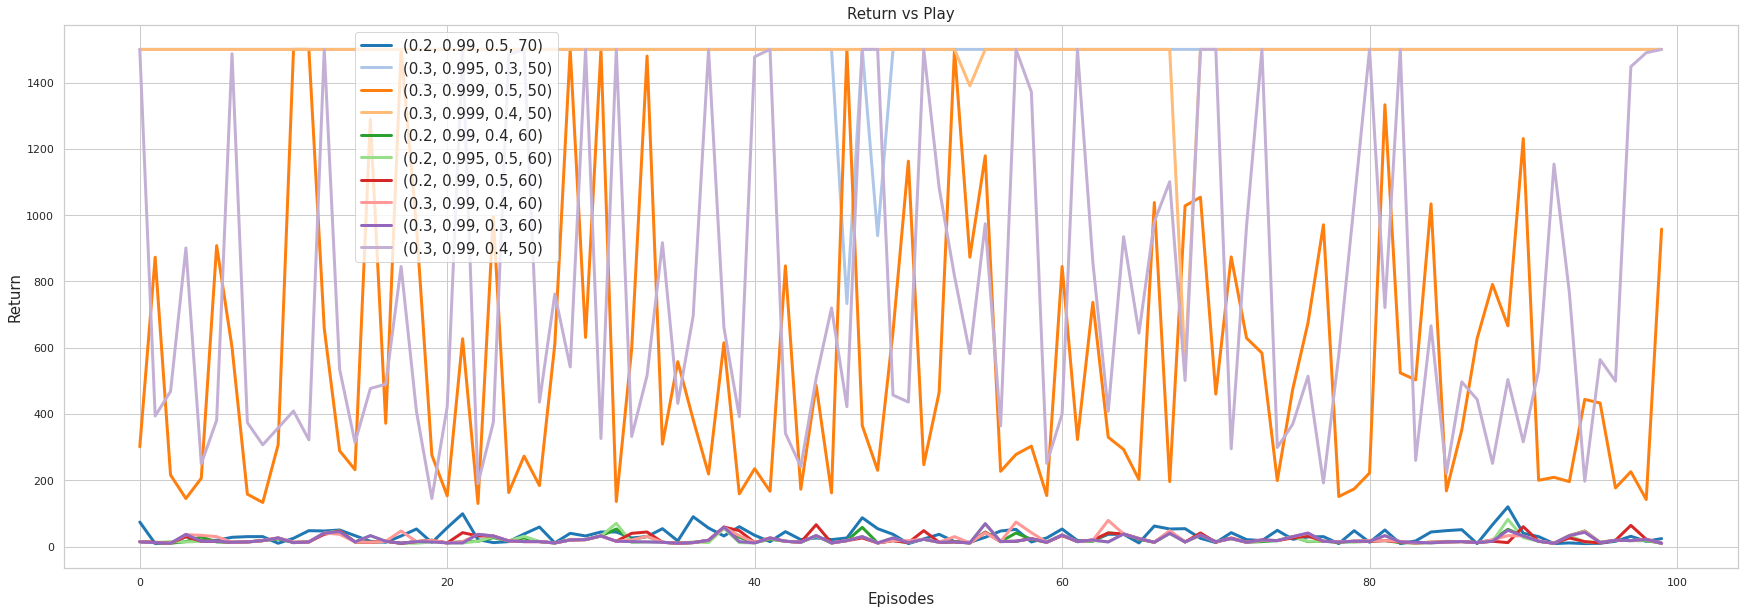

In [ ]:
%matplotlib inline
# to store the plots within the notebook

# plotting the rewards for the 10 models
plot_curves(random_hyperparameters)

In [ ]:
# creating a dataframe containing the tests resuts
df = pd.DataFrame(test_result).T

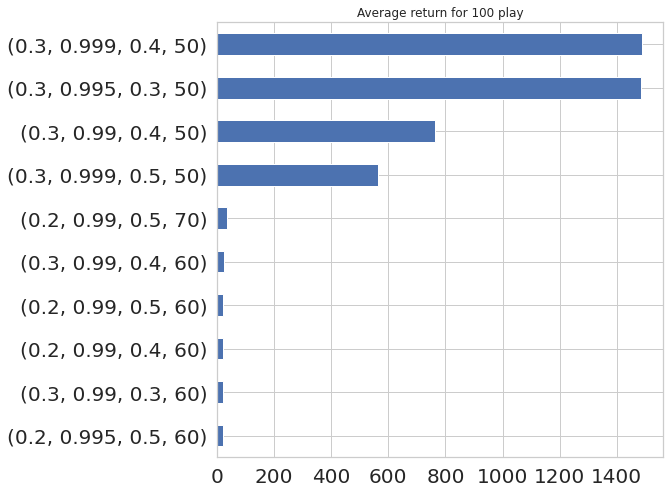

In [ ]:
# plotting the histogram of the average return for 100 play
_ = df[1].sort_values(ascending=True).plot.barh(figsize=(8,8),
                                                title='Average return for 100 play',
                                                fontsize=20)

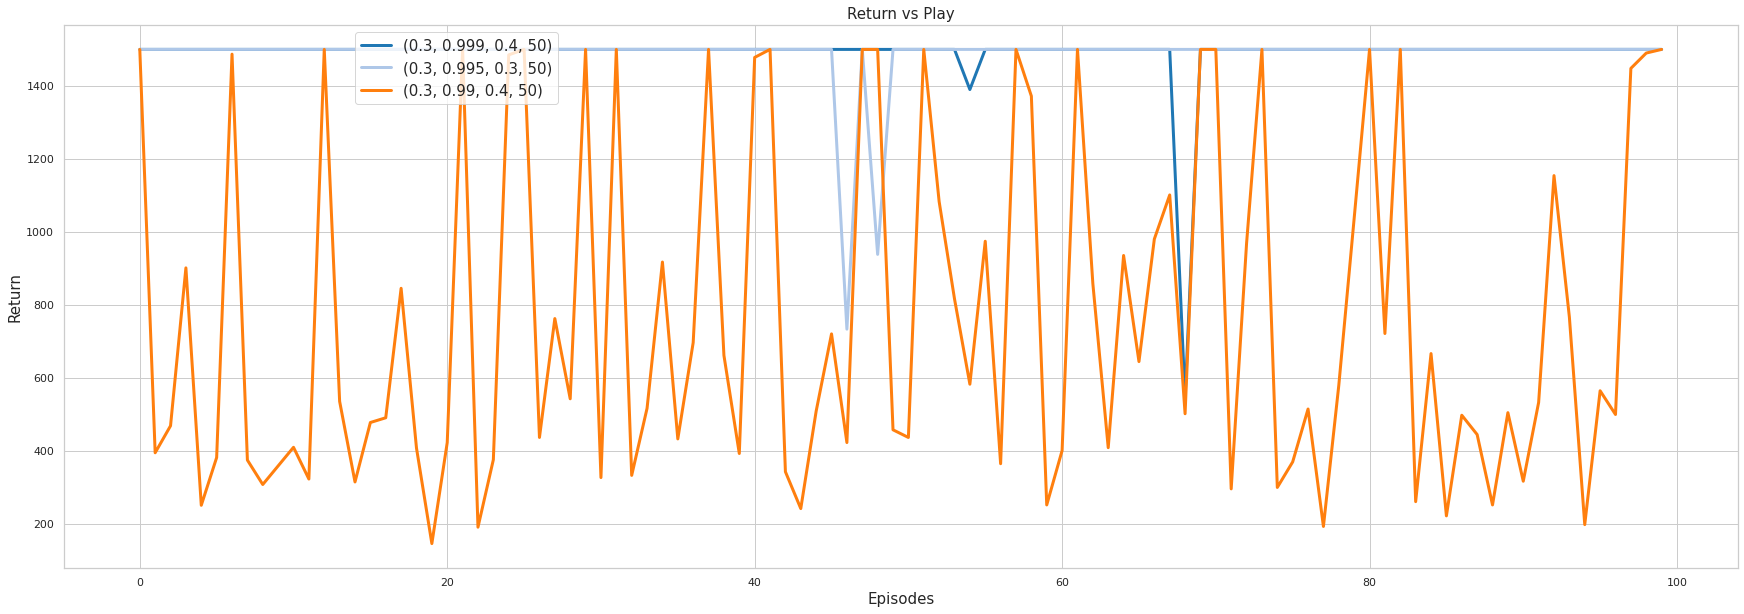

In [ ]:
# just plotting the 3 best models
best_3 = [(0.3, 0.999, 0.4, 50), (0.3, 0.995, 0.3, 50), (0.3, 0.99, 0.4, 50)]
plot_curves(best_3)

# Playing using the best policy

##  Defining function for displaying the game

In [ ]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=20):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

## Creating a model with the best hyperparameters

In [ ]:
%%time

# setting the bin size
bin_size = 50

# setting the number of episode
num_episodes=30000

# creating a bins for the discrete values of the 4 components
# of a state
bins = create_state_bins(bin_size)

# learning the Q-table
q_table, return_list= q_learn(num_episodes=num_episodes,
                              gamma=0.999,
                              learning_rate=0.3,
                              epsilon=0.4,
                              bins=bins,
                              bin_size=bin_size)

CPU times: user 4min 14s, sys: 4.96 s, total: 4min 19s
Wall time: 4min 13s


## Playing the game using the best policy

In [ ]:
# Colorful outputs
class bcolors:
    RED       = '\033[91m'
    OKBLUE    = '\033[94m'
    BOLD      = '\033[1m'
    UNDERLINE = '\033[4m'
    ENDC      = '\033[0m'

In [ ]:
from IPython.display import clear_output
import time

display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
display.start()

frames = []

discrete_state = discretize_state(env.reset(), bins, bin_size)
done = False

counter = 0
while not done:
    action = np.argmax(q_table[discrete_state])
    new_state, reward, done, _ = env.step(action)
    discrete_state = discretize_state(new_state, bins, bin_size)
    img = env.render(mode="rgb_array")
    frames.append(img)
    counter += 1
    clear_output(wait=True)

print(bcolors.BOLD + bcolors.OKBLUE +
    "\nNumber of Steps:" + bcolors.ENDC + bcolors.ENDC,
    counter)



Number of Steps: 1500


In [ ]:
# plotting the animation
plot_animation(frames)

## Comment
**<font color="green">We won the cartPole game for 1500 frames!</font>**